In [1]:
#!/usr/bin/env python
import os
import numpy as np
import tensorflow as tf
from data_utils import train_cached_features_dataset, train_img_dataset, run_dataset_through_network
from data_utils import _LoadPreTrainedWeights
from vgg_network import VGG_Network
from estimator_svdd import SVDDClassifier
from estimator_ocsvm import OCSVMClassifier
from sklearn.externals import joblib
from sklearn.svm import OneClassSVM
from flags import FLAGS

/Users/Sylvain/.pyenv/versions/3.6.4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:
class_nbr = 6
batch_size = 128
cnn_output_dir = '../tmp/cnn_output/VGG16'
cnn_out_dims = 25088

# Training

In [30]:
def input_fn_train():
    with tf.name_scope('input_dataset'):
        dataset = train_cached_features_dataset(class_nbr, cnn_output_dir, cnn_out_dims)
        dataset = dataset.shuffle(1000).batch(batch_size)
        return dataset

x_train = []
input_fn = input_fn_train().make_one_shot_iterator().get_next()
with tf.Session() as sess:
    while True:
        try:
            data = sess.run(input_fn)
            for i in range(data.shape[0]):
                x_train.append(data[i])
        except tf.errors.OutOfRangeError:
            break
x_train = np.asarray(x_train)
classifier = OneClassSVM(kernel='linear', nu=0.7, max_iter=10)

In [31]:
x_train.shape

(850, 25088)

In [32]:
classifier.fit(x_train)

/Users/Sylvain/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto',
      kernel='linear', max_iter=10, nu=0.7, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

# Validation

INFO:tensorflow:(300,)
Confusion matrix, without normalization
INFO:tensorflow:[[ 89  61]
 [ 43 107]]


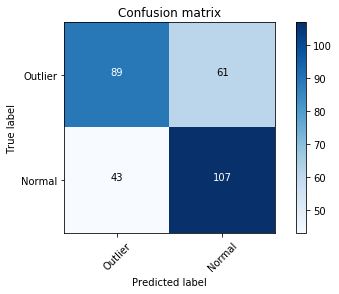

In [33]:
import itertools
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from estimator_svdd import SVDDClassifier
from estimator_ocsvm import OCSVMClassifier
from sklearn.externals import joblib
from sklearn.svm import OneClassSVM
from vgg_network import VGG_Network
from data_utils import test_cached_features_dataset, test_img_dataset, run_dataset_through_network
from data_utils import _LoadPreTrainedWeights

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    tf.logging.info(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm[0].sum() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def evaluation_summary(y_true, y_pred, plot_cm=False):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    if plot_cm:
        plot_confusion_matrix(cm, classes=["Outlier", "Normal"],
                              normalize=False, title='Confusion matrix')

    return pd.Series({
        "Accuracy": acc,
        "Precision": pre,
        "Recall": rec,
        "f1-score": f1
    })


input_fn_test = lambda: test_cached_features_dataset(class_nbr, cnn_output_dir, cnn_out_dims)\
                         .batch(batch_size)

x_test = []
input_fn = test_cached_features_dataset(class_nbr, cnn_output_dir, cnn_out_dims).batch(1)
input_fn = input_fn.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    while True:
        try:
            data = sess.run(input_fn)
            x_test.append(data[0][0])
        except tf.errors.OutOfRangeError:
            break
x_test = np.asarray(x_test)
test_predicted_classes = classifier.predict(x_test)

# Get true labels
y_test = []
input_fn = test_cached_features_dataset(class_nbr, cnn_output_dir, cnn_out_dims).batch(1)
input_fn = input_fn.make_one_shot_iterator().get_next()
sess = tf.Session()
while True:
    try:
        data = sess.run(input_fn)
        y_test.append(data[1][0])
    except tf.errors.OutOfRangeError:
        break
y_test = np.asarray(y_test)
tf.logging.info(y_test.shape)

s = evaluation_summary(y_test, test_predicted_classes, plot_cm=True)

In [34]:
s

Accuracy     0.653333
Precision    0.636905
Recall       0.713333
f1-score     0.672956
dtype: float64